Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Training Accuracy: 0.97
Testing Accuracy: 0.89
Real Testing Accuracy: 0.40


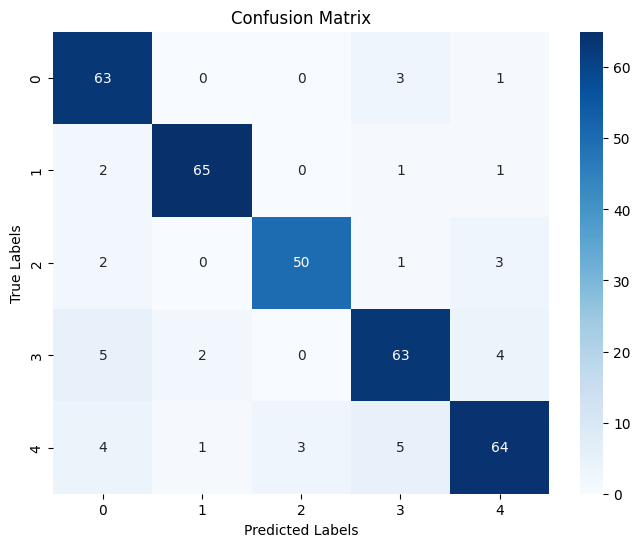

False Negative Rate for Class 0: 0.06
False Negative Rate for Class 1: 0.06
False Negative Rate for Class 2: 0.11
False Negative Rate for Class 3: 0.15
False Negative Rate for Class 4: 0.17

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        67
           1       0.96      0.94      0.95        69
           2       0.94      0.89      0.92        56
           3       0.86      0.85      0.86        74
           4       0.88      0.83      0.85        77

    accuracy                           0.89       343
   macro avg       0.89      0.89      0.89       343
weighted avg       0.89      0.89      0.89       343



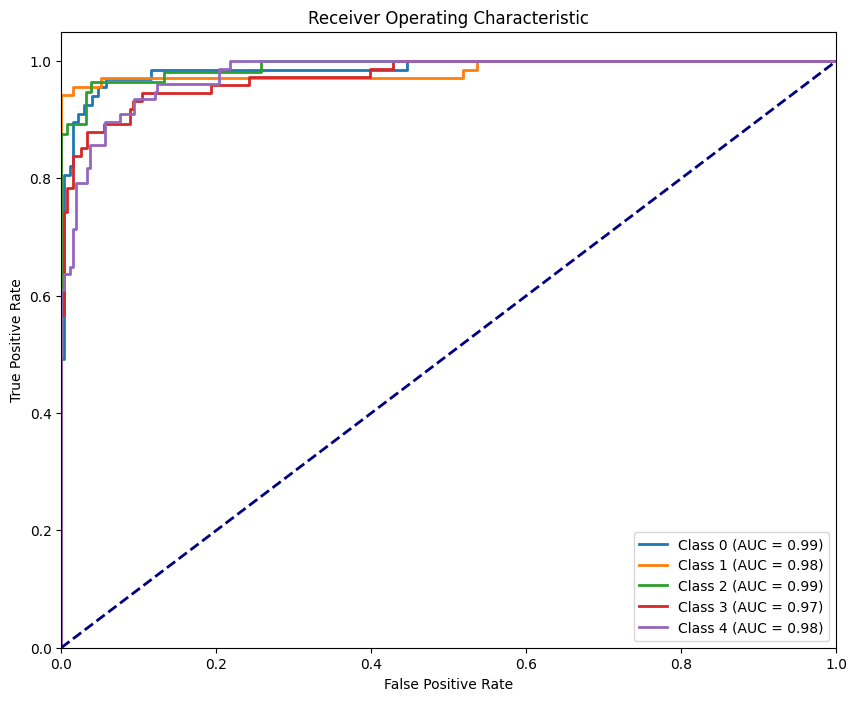

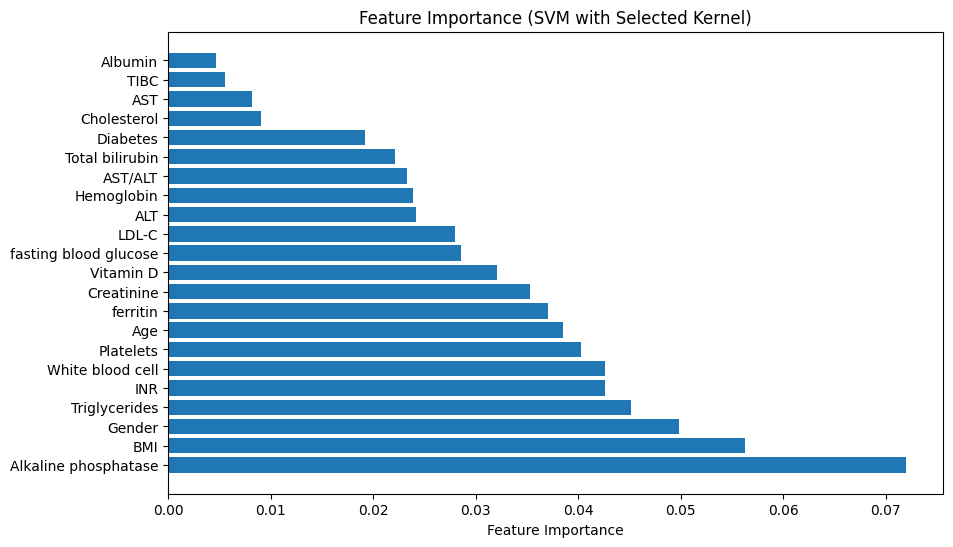

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# Load training dataset
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)


# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Hyperparameter tuning for SVM
param_grid = {
    'C': [ 0.01, 0.1],
    'gamma': [0.1, 1],
    'kernel': ['rbf']
}


skf = StratifiedKFold(n_splits=5)
grid = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid, cv=skf, scoring='accuracy')

grid.fit(X_train, y_train)

# Best Model
model_svm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

train_acc = model_svm.score(X_train, y_train)
test_acc = model_svm.score(X_test_combined, y_test_combined)
real_test_acc = model_svm.score(test_data_from_file.drop('steato score', axis=1),test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"Real Testing Accuracy: {real_test_acc:.2f}")

# Evaluation on combined test data
y_test_pred_combined = model_svm.predict(X_test_combined)
y_test_prob_combined = model_svm.predict_proba(X_test_combined)

# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
classes = np.unique(y_test_combined)
plot_confusion_matrix(cm_combined, classes)

# False Negative Rate for each class
fn_rate_per_class = []
for i in range(len(cm_combined)):
    FN = sum(cm_combined[i, :]) - cm_combined[i, i]
    TP = cm_combined[i, i]
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    fn_rate_per_class.append(FNR)

for i, fnr in enumerate(fn_rate_per_class):
    print(f"False Negative Rate for Class {classes[i]}: {fnr:.2f}")

# Classification Report
classes = np.unique(y_test_combined)  # Unique classes
report_dt = classification_report(y_test_combined, y_test_pred_combined, target_names=classes.astype(str))
print("\nClassification Report:\n", report_dt)


# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(model_svm.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[cls]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
results = permutation_importance(model_svm, X_test_combined, y_test_combined, scoring='accuracy', n_repeats=10, random_state=42)
importance_scores = results.importances_mean
sorted_idx = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importance_scores[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (SVM with Selected Kernel)')
plt.show()



Top Features for Class 0 based on predict_proba:
Diabetes: 0.0023
Triglycerides: 0.0015
Hemoglobin: 0.0003
AST: 0.0000
fasting blood glucose: -0.0009
Creatinine: -0.0020
Cholesterol: -0.0020
Albumin: -0.0026
Total bilirubin: -0.0032
TIBC: -0.0044
AST/ALT: -0.0070
Vitamin D: -0.0090
White blood cell: -0.0093
Platelets: -0.0111
Gender: -0.0117
ferritin: -0.0125
ALT: -0.0125
Age: -0.0128
LDL-C: -0.0166
BMI: -0.0192
INR: -0.0309
Alkaline phosphatase: -0.0490


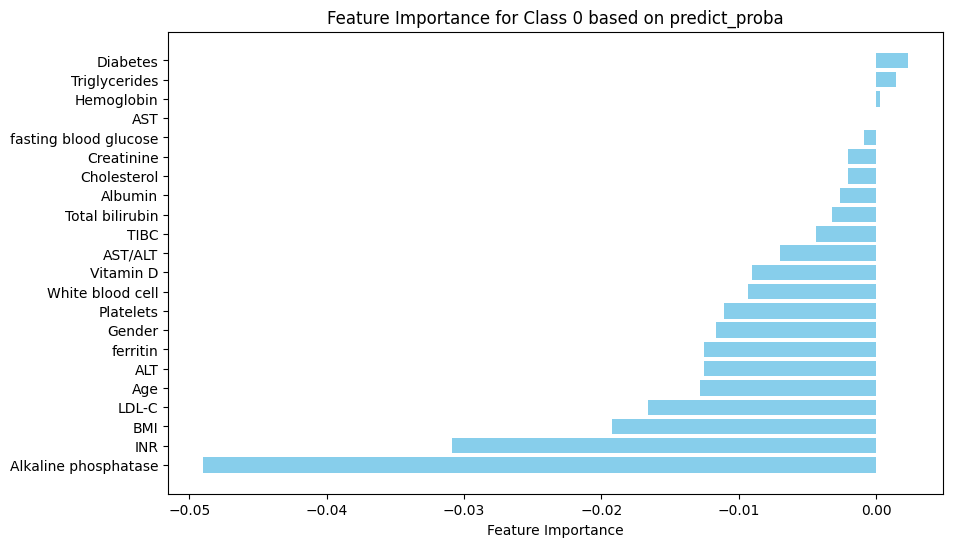


Top Features for Class 1 based on predict_proba:
Triglycerides: 0.0242
Alkaline phosphatase: 0.0219
fasting blood glucose: 0.0160
INR: 0.0128
Diabetes: 0.0105
Hemoglobin: 0.0073
AST: 0.0067
Total bilirubin: 0.0067
Vitamin D: 0.0050
AST/ALT: 0.0047
Creatinine: 0.0038
Albumin: 0.0029
Cholesterol: 0.0012
Gender: 0.0009
Age: -0.0012
TIBC: -0.0017
Platelets: -0.0032
LDL-C: -0.0035
BMI: -0.0035
White blood cell: -0.0050
ALT: -0.0050
ferritin: -0.0061


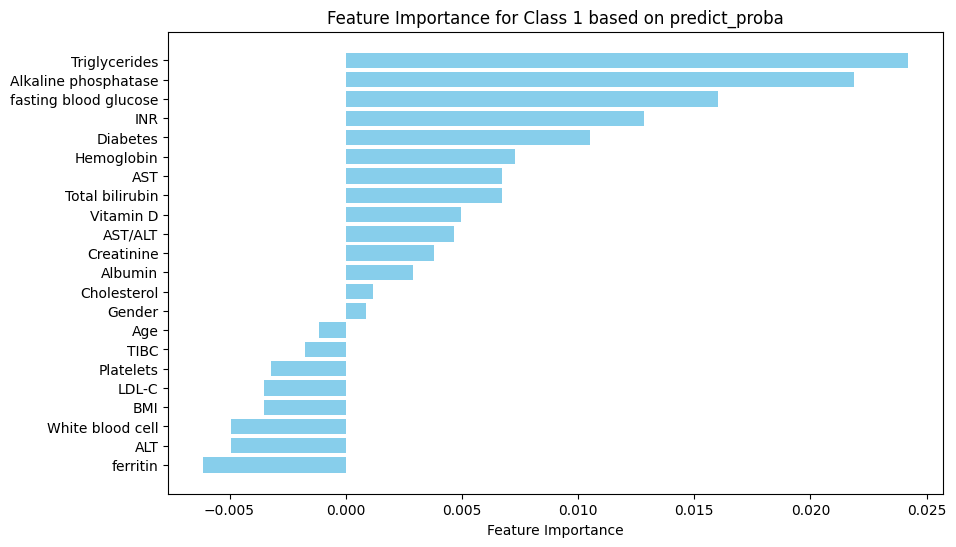


Top Features for Class 2 based on predict_proba:
Triglycerides: 0.0233
Creatinine: 0.0120
Diabetes: 0.0117
Hemoglobin: 0.0099
Gender: 0.0093
fasting blood glucose: 0.0085
ALT: 0.0085
Cholesterol: 0.0070
AST: 0.0067
Age: 0.0064
Total bilirubin: 0.0041
Albumin: 0.0012
Vitamin D: -0.0003
AST/ALT: -0.0003
TIBC: -0.0012
BMI: -0.0012
LDL-C: -0.0017
Platelets: -0.0020
White blood cell: -0.0041
ferritin: -0.0064
INR: -0.0213
Alkaline phosphatase: -0.0423


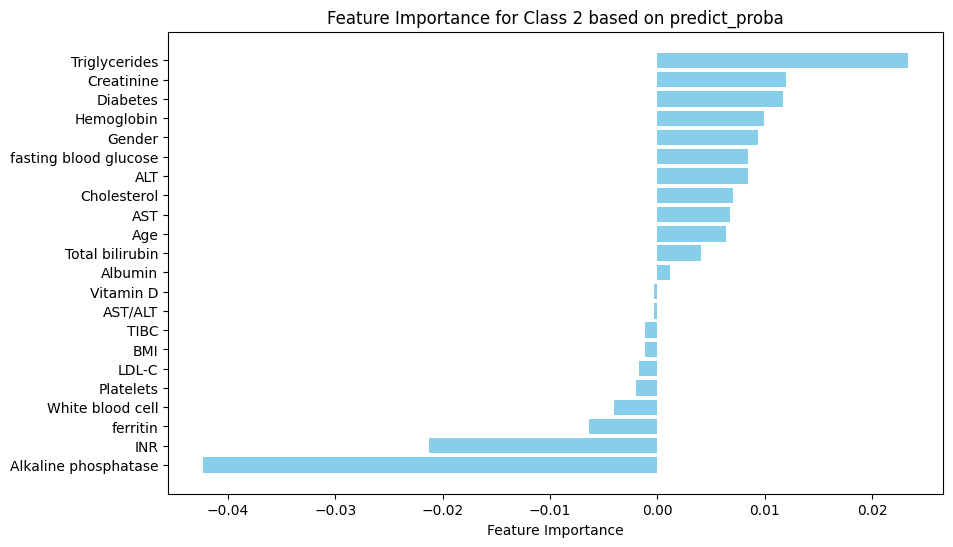


Top Features for Class 3 based on predict_proba:
Triglycerides: 0.0210
Diabetes: 0.0096
AST: 0.0070
fasting blood glucose: 0.0061
ferritin: 0.0038
Total bilirubin: 0.0035
Hemoglobin: 0.0029
Albumin: 0.0023
Creatinine: 0.0020
Age: 0.0012
Gender: 0.0003
Vitamin D: -0.0009
Platelets: -0.0017
AST/ALT: -0.0023
BMI: -0.0023
TIBC: -0.0026
Cholesterol: -0.0026
ALT: -0.0032
White blood cell: -0.0044
LDL-C: -0.0152
INR: -0.0251
Alkaline phosphatase: -0.0449


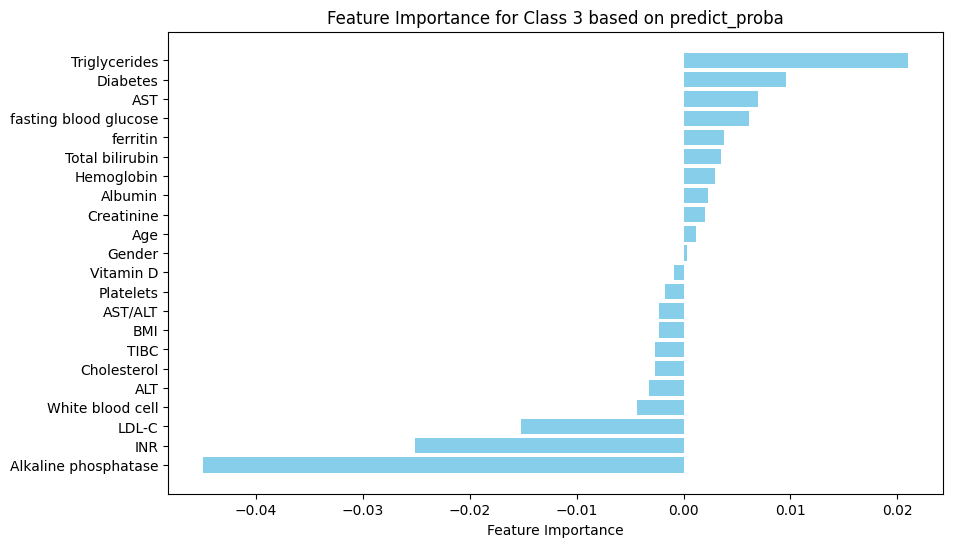


Top Features for Class 4 based on predict_proba:
Triglycerides: 0.0233
BMI: 0.0195
Diabetes: 0.0082
fasting blood glucose: 0.0079
AST: 0.0076
Hemoglobin: 0.0073
Total bilirubin: 0.0058
Creatinine: 0.0050
Gender: 0.0044
AST/ALT: 0.0035
Age: 0.0029
Vitamin D: 0.0029
Albumin: 0.0026
Cholesterol: 0.0020
TIBC: -0.0012
White blood cell: -0.0015
ALT: -0.0026
ferritin: -0.0044
Platelets: -0.0058
LDL-C: -0.0096
INR: -0.0213
Alkaline phosphatase: -0.0373


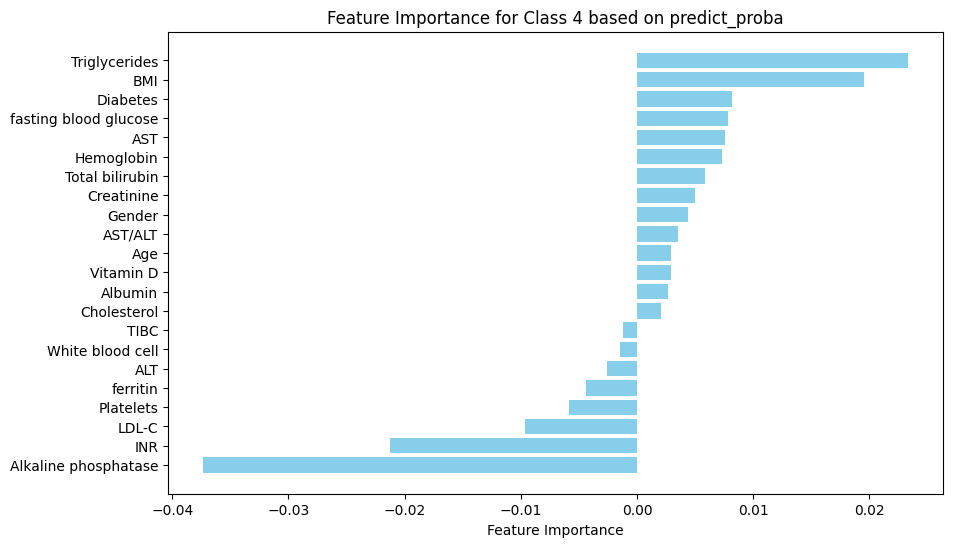

In [4]:
from sklearn.metrics import confusion_matrix

# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba = {}

for class_index, cls in enumerate(model_svm.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = model_svm.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    importance_scores = permutation_importance(model_svm, X_test_combined, y_binary,
                                               scoring='accuracy', n_repeats=10, random_state=42).importances_mean

    # Sort by importance (descending)
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
